In [28]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [10]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [11]:
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

(150, 2)


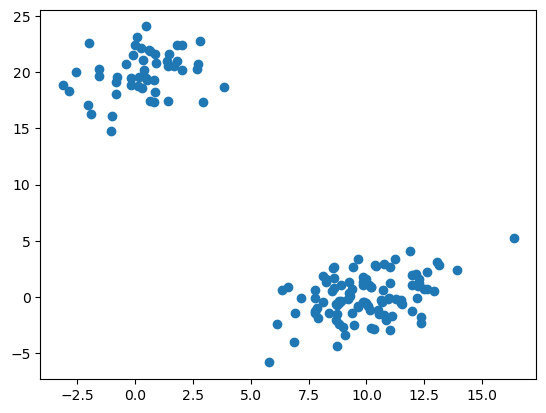

In [13]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print (X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

In [14]:

# generate the linkage matrix
Z = linkage(X, 'ward')

In [15]:

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.9800148387574268

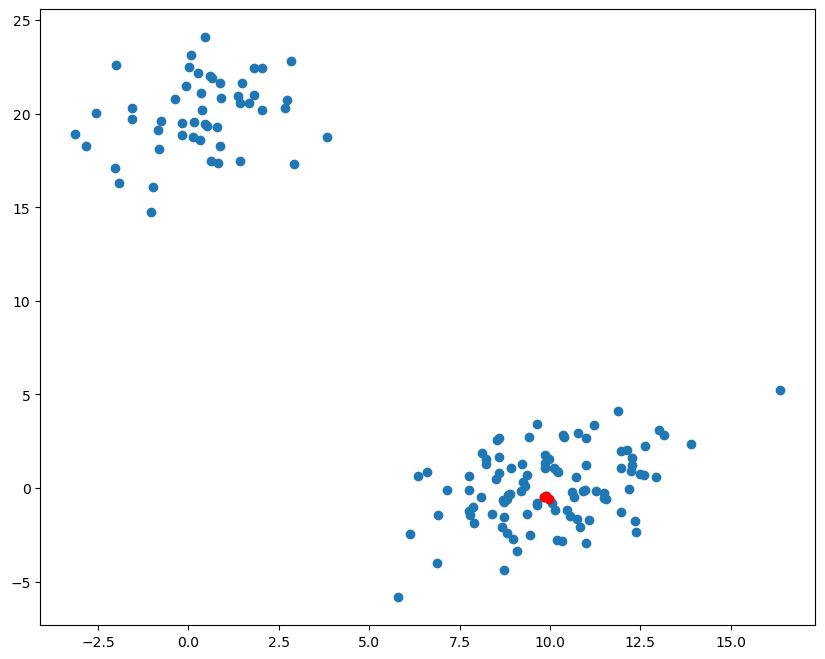

In [16]:
idxs = [33, 68, 62]
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.show()

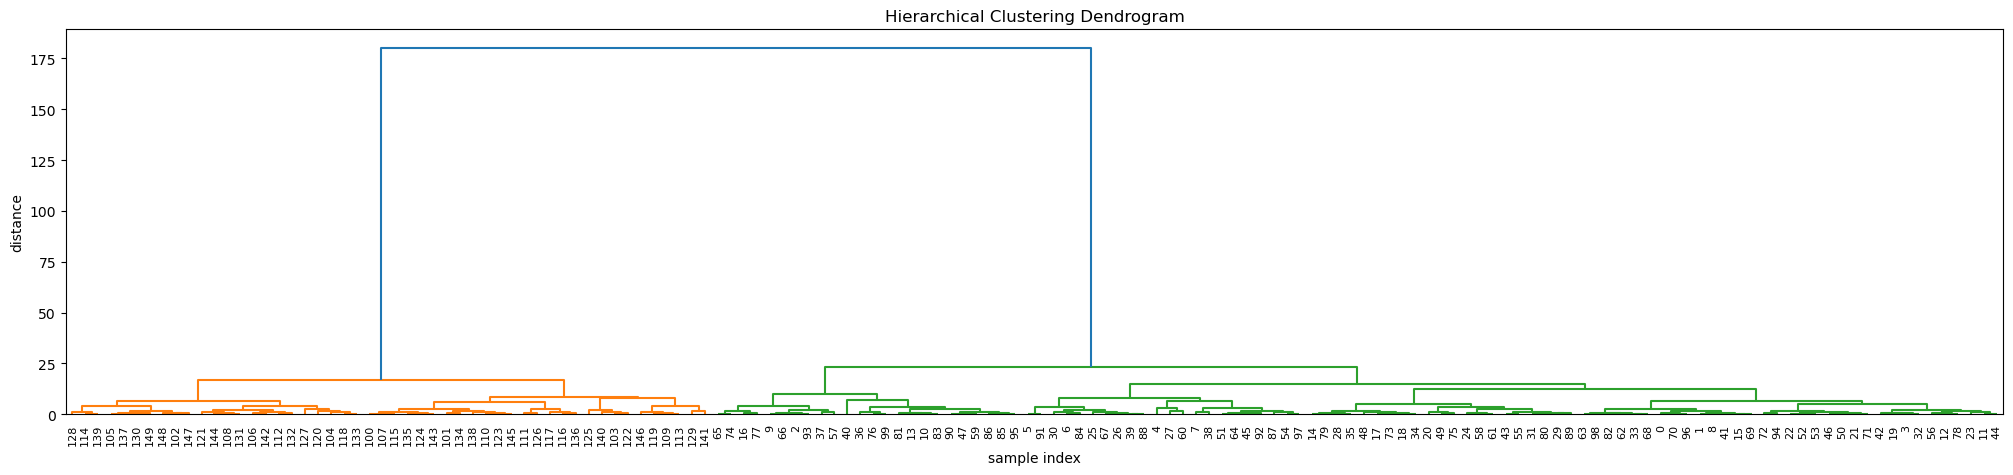

In [20]:

# calculate full dendrogram
plt.figure(figsize=(25, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

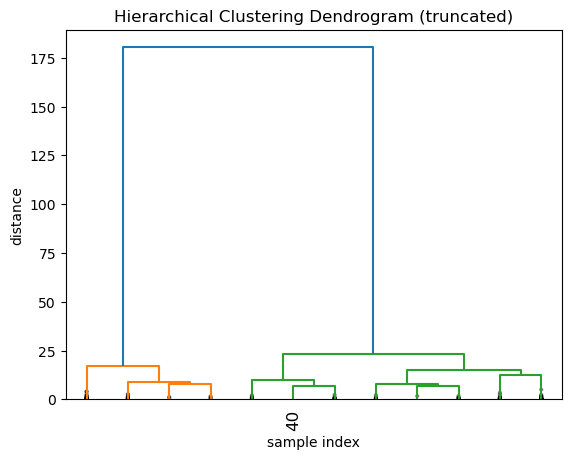

In [21]:

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

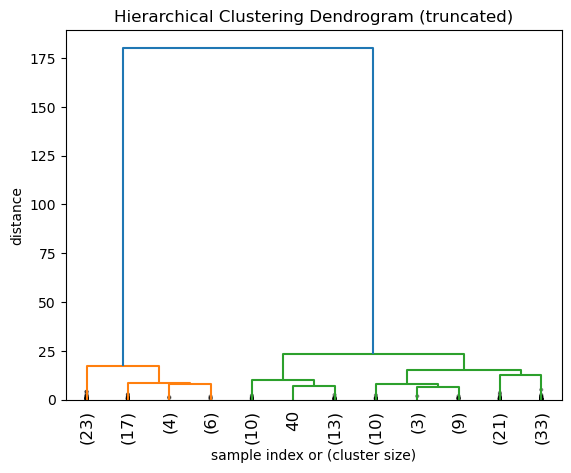

In [22]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [23]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

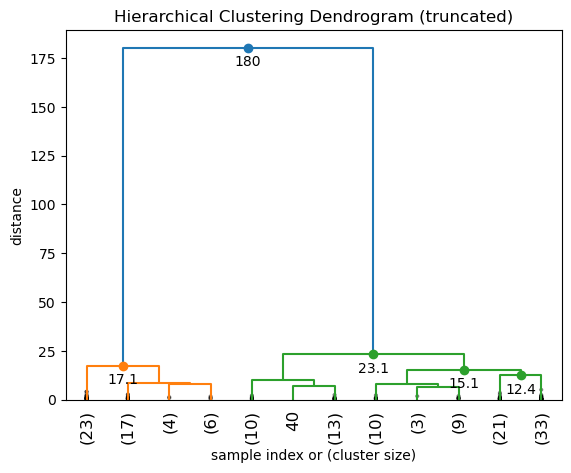

In [24]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [25]:
# set cut-off to 50
max_d = 50  # max_d as in max_distance

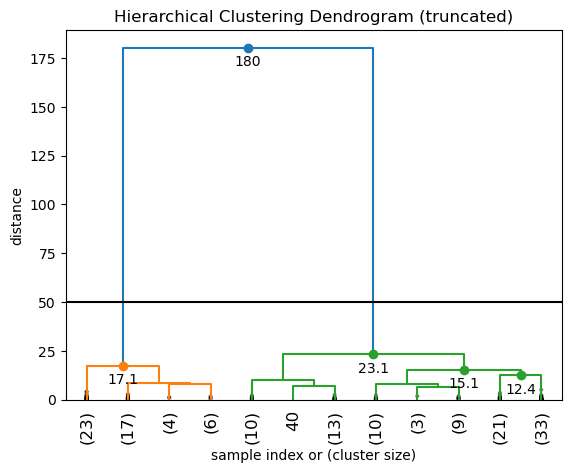

In [26]:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

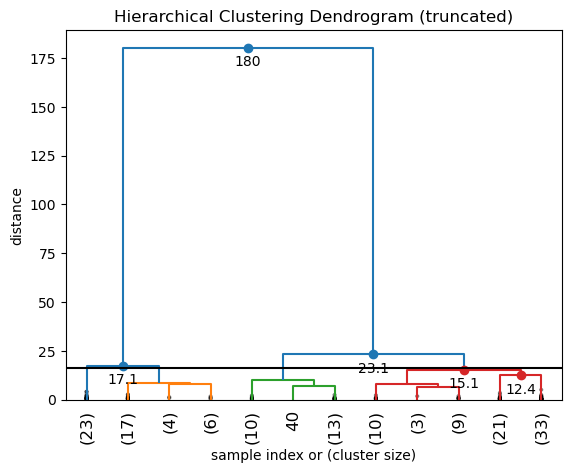

In [27]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

 # _New

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class HierarchicalClustering:
    def __init__(self, data, linkage='single'):
        """
        Initialize clustering algorithm with validation checks
        :param data: Input data matrix (n_samples, n_features)
        :param linkage: Cluster distance metric ('single', 'complete', 'average')
        """
        self.data = np.array(data)
        self.n_samples = self.data.shape[0]
        self.linkage = linkage
        self.distance_matrix = self._compute_initial_distances()
        self.clusters = [[i] for i in range(self.n_samples)]
        self.merges = []  # Stores linkage history for dendrogram
        
    def _compute_initial_distances(self):
        """Compute pairwise Euclidean distances between all points"""
        dist = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            for j in range(i+1, self.n_samples):
                dist[i,j] = np.linalg.norm(self.data[i] - self.data[j])
        return dist

    def _cluster_distance(self, c1, c2):
        """Compute distance between two clusters based on linkage method"""
        if self.linkage == 'single':
            return min(self.distance_matrix[i,j] for i in c1 for j in c2)
        elif self.linkage == 'complete':
            return max(self.distance_matrix[i,j] for i in c1 for j in c2)
        elif self.linkage == 'average':
            total = sum(self.distance_matrix[i,j] for i in c1 for j in c2)
            return total / (len(c1)*len(c2))
        else:
            raise ValueError("Invalid linkage method")

    def _update_distance_matrix(self, new_cluster, remaining_clusters):
        """Update distance matrix after merge using Lance-Williams formula"""
        new_dist = []
        for cluster in remaining_clusters:
            if cluster != new_cluster:
                dist = self._cluster_distance(new_cluster, cluster)
                new_dist.append(dist)
        return new_dist

    def fit(self):
        """Perform hierarchical clustering using agglomerative approach"""
        while len(self.clusters) > 1:
            # Find closest clusters
            min_dist = np.inf
            merge_indices = (0, 0)
            
            for i in range(len(self.clusters)):
                for j in range(i+1, len(self.clusters)):
                    dist = self._cluster_distance(self.clusters[i], self.clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        merge_indices = (i, j)
            
            # Merge clusters and record merge history
            i, j = merge_indices
            merged = self.clusters[i] + self.clusters[j]
            self.merges.append({
                'merged_clusters': (self.clusters[i], self.clusters[j]),
                'distance': min_dist,
                'new_cluster': merged
            })
            
            # Update cluster list and distance matrix
            del self.clusters[j]
            del self.clusters[i]
            self.clusters.append(merged)
            
    def plot_dendrogram(self):
        """Plot dendrogram using merge history"""
        # Create position dictionary for leaf nodes
        pos = {i: i for i in range(self.n_samples)}
        current_x = self.n_samples
        
        plt.figure(figsize=(10, 6))
        
        for merge in self.merges:
            cluster1, cluster2 = merge['merged_clusters']
            dist = merge['distance']
            
            # Get x positions for clusters
            x1 = np.mean([pos[node] for node in cluster1])
            x2 = np.mean([pos[node] for node in cluster2])
            
            # Draw vertical lines and horizontal connection
            plt.plot([x1, x1], [0, dist], 'b')
            plt.plot([x2, x2], [0, dist], 'b')
            plt.plot([x1, x2], [dist, dist], 'b')
            
            # Update position for new cluster
            new_x = (x1 + x2) / 2
            for node in cluster1 + cluster2:
                pos[node] = new_x
                
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.title(f'Hierarchical Clustering Dendrogram ({self.linkage.title()} Linkage)')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Sample data: Fruit weights (apple, banana, cherry, grape)
    data = [[100], [120], [50], [30]]
    
    hc = HierarchicalClustering(data, linkage='single')
    hc.fit()
    hc.plot_dendrogram()


: 